In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from fastai import text

In [3]:
path = Path('data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('data')

In [4]:
reviews_sampled_df = pd.read_csv(path/'reviews_sampled.tsv', sep='\t')
print(reviews_sampled_df.shape[0])
reviews_sampled_df.sample()

480420


,review_body,star_rating,rating
310929,this port is the worst way to play silent hill...,1,0


### Training the language model

In [5]:
data_lm = (text.TextList.from_df(reviews_sampled_df, path, cols='review_body')
            .random_split_by_pct(0.1)
            .label_for_lm()
            .databunch(bs=64))

In [6]:
data_lm.show_batch(1)

idx,text
0,be hard as hell to remove ! xxmaj my advice would be to try and refurbish the old 72 pin if possible . xxmaj do n't waste your money like i did . xxbos xxmaj this was way too hard for my kids . xxmaj we have tried it with kids ages 4 - 7 and none of them have had fun doing it . xxmaj it 's a little


In [7]:
learn = text.language_model_learner(data_lm, pretrained_model=text.URLs.WT103_1, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


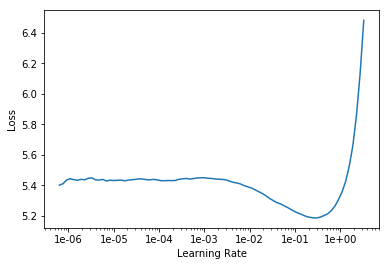

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.866106,3.734239,0.297499


In [10]:
learn.save('fit_head')

In [11]:
learn.load('fit_head');

In [12]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


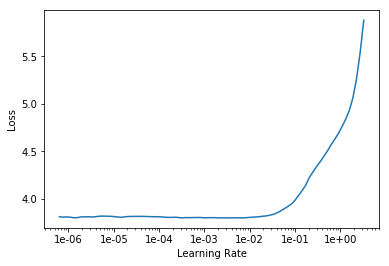

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.477256,3.415504,0.336901


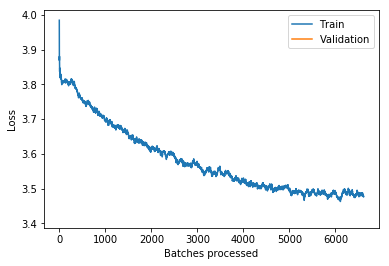

In [19]:
learn.recorder.plot_losses()

In [15]:
learn.save('fine_tuned')

In [16]:
learn.load('fine_tuned');

In [17]:
learn.save_encoder('fine_tuned_enc')

In [18]:
def generate_sentences(begin_with, n_words, n_sentences, **kwargs):
    return [learn.predict(begin_with, n_words, **kwargs) for _ in range(n_sentences)]

generate_sentences("I liked this game because", 40, 2, temperature=0.75)

["I liked this game because of the fact that it was such a great game . i play . xxbos xxmaj this game is not fun to play . xxmaj you ca n't play it . xxmaj the missions are very frustrating . xxmaj the",
 "I liked this game because it was the actual game . xxmaj this game has so many good story lines and series to keep the eye out of the story . xxmaj it keeps me busy for hours and i do n't care for how"]

### Training the classifier

In [20]:
data_clas = (text.TextList.from_df(reviews_sampled_df, path, cols='review_body', vocab=data_lm.vocab)
             .random_split_by_pct(0.1)
             .label_from_df(cols='rating')
             .databunch(bs=64))

In [21]:
data_clas.show_batch(1)

text,target
"xxbos xxup what , xxup i'm xxup writing xxup this xxup review xxup about 4 xxup to 5 xxup years xxup after xxup this xxup game xxup was xxup released . xxup but xxup who xxup cares , xxup this xxup game xxup is xxup the xxup best xxup multiplayer xxup game xxup ever ! ! ! xxup and xxup i'll xxup say xxup that xxup with xxup no xxup",1


In [22]:
learn = text.text_classifier_learner(data_clas, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


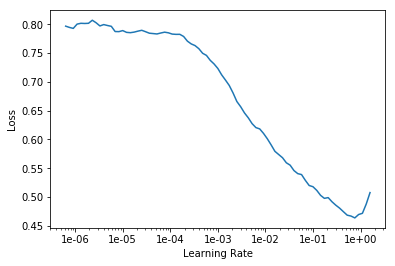

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.258551,0.174899,0.933267


In [25]:
learn.save('first_clas')

In [26]:
learn.load('first_clas');

In [27]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


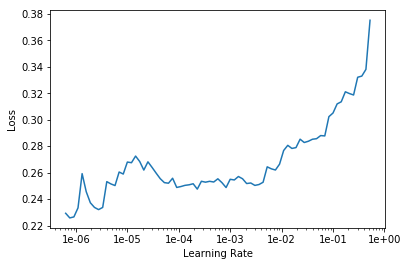

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.184174,0.150009,0.943612


In [30]:
learn.save('second_clas')

In [31]:
learn.load('second_clas');

In [32]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


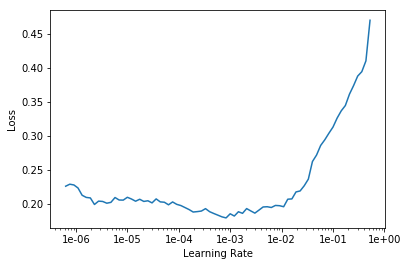

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.143461,0.121543,0.956788


In [35]:
learn.save('third_clas')

In [36]:
learn.load('third_clas');

In [37]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


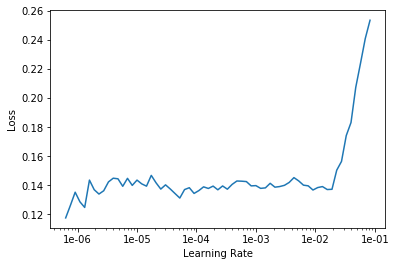

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.115787,0.120575,0.957953


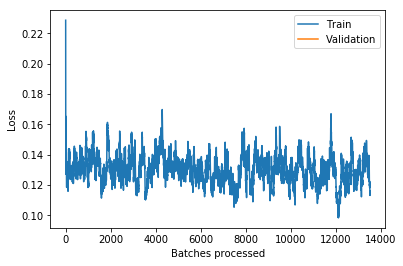

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save('fine_tuned_clas')

In [42]:
learn.load('fine_tuned_clas');

### Evaluating the classifier

In [44]:
outputs, targets = learn.get_preds(text.DatasetType.Valid)

In [98]:
outputs = outputs.detach().numpy()
targets = targets.detach().numpy()

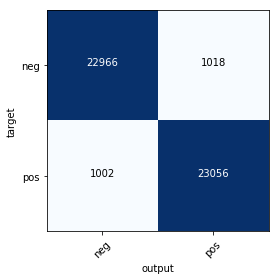

In [150]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('target')
    plt.xlabel('output')
    plt.tight_layout()

cm = confusion_matrix(targets, outputs.argmax(axis=1))
plot_confusion_matrix(cm, ['neg', 'pos'])

In [176]:
from sklearn.metrics import log_loss

def get_losses(outputs, targets):
    onehot = np.array(list(zip(1-targets, targets)))
    losses = np.array([log_loss(y, y_hat) for y_hat, y in zip(*(outputs, onehot))])
    return losses

losses = get_losses(outputs, targets)

In [194]:
from IPython.display import display, Markdown

def top_losses(outputs, targets, losses, n=5):
    losses_df = pd.DataFrame(columns=['output', 'target', 'text'])
    for i, (o, t, l) in sorted(enumerate(zip(*(outputs, targets, losses))), key=lambda x: -x[1][2])[:n]:
        print('output: {:.4f}, target: {}'.format(o[1], t))
        display(Markdown('> {}'.format(learn.data.valid_ds[i][0])))

top_losses(outputs, targets, losses)

output: 0.0769, target: 1


> xxbos this game is over xxunk by hackers and retarded lags and horrible host migration and people xxunk you to level 1 . i used to love this game but hate it . i just got hacked this very moment of this review .

output: 0.8534, target: 0


> xxbos bad controller left analog stick did n't function properly and the l2 and r2 were stuck and it was n't working with my call of duty game

output: 0.5172, target: 0


> xxbos xxmaj the product purchased was a charger . xxmaj works as required . xxmaj bought 2 just in case . xxmaj happy with this purchase . ( it 's not a game )

output: 0.5191, target: 1


> xxbos i hated xxmaj zoo tycoon 2 . i got the first zoo tycoon and xxup loved it so i decided to get zoo tycoon 2 and i hated it . xxmaj first one is xxup way better . i would nt suggest this .

output: 0.3101, target: 0


> xxbos xxup do xxup not xxup buy xxup it 
 xxup its xxup pathetic xxup compared xxup to xxup previous xxup cods 
 xxup infinity xxup ward xxup go xxup home , xxup you xxup suck 
 xxup treyarch xxup does xxup it xxup better

In [183]:
with open('test/red-dead-redemption-2.txt', 'r') as f:
    print(learn.predict(f.read()))

(Category 0, tensor(0), tensor([0.9833, 0.0167]))


In [184]:
with open('test/resident-evil-2.txt', 'r') as f:
    print(learn.predict(f.read()))

(Category 1, tensor(1), tensor([0.0032, 0.9968]))
